# E-Commerce Customer Segmentation Using K-Means Algorithm 
RFM is one of the most popular methods used in customer segmentation problems. RFM stands for three key pieces of information:
- **Recency**: The last period of time when a customer made a transaction.
- **Frequency**: The frequency of a customer's purchases.
- **Monetary**: The amount of money customers spend on your business.

In this analysis, I will apply the K-means algorithm to cluster customers. From this, we can see how this method addresses real-world problems.








## Table of content
- [1 - Introduction about the dataset](#1)
- [2 - Data Pre-processing](#2)
    - [2.1 - Data exploration and cleaning](#2.1)
    - [2.2 - Data standardization for K-mean](#2.2)
- [3 - Applying K-means clustering](#3)
    - [3.1 - Determine the optimal number of $k$ clusters using Elbow method](#3.1)
    - [3.2 - Implementing the K-means algorithm with $k$ clusters](#3.2)

## Load package

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

<a name='1'></a>
## 1 - Introduction about the dataset

**Dataset for analysis:** [E-Commerce Data](https://www.kaggle.com/datasets/carrie1/ecommerce-data/data") (click to download the dataset from Kaggle)

**Introduction:** This dataset contains all actual transactions from 01/12/2010 to 09/12/2011 for a UK-based, registered non-store online retailer. The company primarily sells unique all-occasion gifts, with many of its customers being wholesalers.

**About the Dateset:**
- InvoiceNo: the unique identifier for each transaction invoice
- StockCode: the unique code assigned to each item in the transaction
- Description: the brief description or name of the item in the transaction
- Quantity: the number of units of each item purchased in the transaction
- InvoiceDate: the date and time when the transaction occurred
- UnitPrice: the price per unit of the item in the transaction
- CustomerID: the unique identifier for the customer who made the transaction
- Country: the country where the customer is located

In [3]:
df = pd.read_csv('data.csv', encoding = 'ISO-8859-1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


<a name='2'></a>
## 2 - Data Pre-processing

<a name='2.1'></a>
### 2.1 - Data exploration and cleaning

In [57]:
# Explore data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In the dataset, the column `CustomerID` contains 25% null values. Since `CustomerID` is key information for segmentation, clustering cannot be performed without knowing who the customer is. Because the main objective is to implement the K-means algorithm and the number of null values is within an acceptable threshold, I therefore remove rows with null values in this column instead of deeply analyzing.

Additionally, the `InvoiceDate` column has `dtype` is object, it needs to be converted to the date type.

In [58]:
# Remove duplicate rows or rows with null values in the CustomerID column
df.drop_duplicates(inplace=True)
df.dropna(subset=['CustomerID'], inplace=True)

# Convert InvoiceDate to the appropriate type
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Check if the column InvoiceDate contains a valid range of time after converting
print("Min InvoiceDate:", df['InvoiceDate'].min())
print("Max InvoiceDate:", df['InvoiceDate'].max())

Min InvoiceDate: 2010-12-01 08:26:00
Max InvoiceDate: 2011-12-09 12:50:00


In [59]:
# Explore data
df.describe()

,Quantity,UnitPrice,CustomerID
count,401604.000000,401604.000000,401604.000000
mean,12.183273,3.474064,15281.160818
std,250.283037,69.764035,1714.006089
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13939.000000
50%,5.000000,1.950000,15145.000000
75%,12.000000,3.750000,16784.000000
max,80995.000000,38970.000000,18287.000000


The `Quantity` and `UnitPrice` columns have negative minimum values that need to be removed.

In [60]:
# Remove rows that contain Quantity and UnitPrice values less than or equal to 0
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
df.describe()

,Quantity,UnitPrice,CustomerID
count,392692.000000,392692.000000,392692.000000
mean,13.119702,3.125914,15287.843865
std,180.492832,22.241836,1713.539549
min,1.000000,0.001000,12346.000000
25%,2.000000,1.250000,13955.000000
50%,6.000000,1.950000,15150.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,8142.750000,18287.000000


<a name='2.2'></a>
### 2.2 - Data standardization for K-mean
As mentioned above, the analysis uses three key pieces of information to provide data for the K-means algorithm: R, F, and M. This section will calculate these metrics and standardize the data in preparation for implementing K-means.

In [61]:
# Calculate the amount of money customers spend per transaction
df['Amount'] = df['Quantity'] * df['UnitPrice']

# Create reference date to calculate recency, assuming this analysis is conducted 1 day after the dataset's cutoff date
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Aggregate data by CustomerID to calculate RFM metrics
recency   = df.groupby('CustomerID')['InvoiceDate'].max().apply(lambda x: (reference_date - x).days)
frequency = df.groupby('CustomerID')['InvoiceNo'].nunique()
monetary  = df.groupby('CustomerID')['Amount'].sum()

rfm_df = pd.DataFrame({
    'Recency': recency,
    'Frequency': frequency,
    'Monetary': monetary
}).reset_index()

rfm_df.describe()

,CustomerID,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000,4338.000000
mean,15300.408022,92.536422,4.272015,2048.688081
std,1721.808492,100.014169,7.697998,8985.230220
min,12346.000000,1.000000,1.000000,3.750000
25%,13813.250000,18.000000,1.000000,306.482500
50%,15299.500000,51.000000,2.000000,668.570000
75%,16778.750000,142.000000,5.000000,1660.597500
max,18287.000000,374.000000,209.000000,280206.020000


K-means is sensitive to non-normal distributions. We need to check the distribution of each metric to ensure it is suitable for implementing the algorithm.

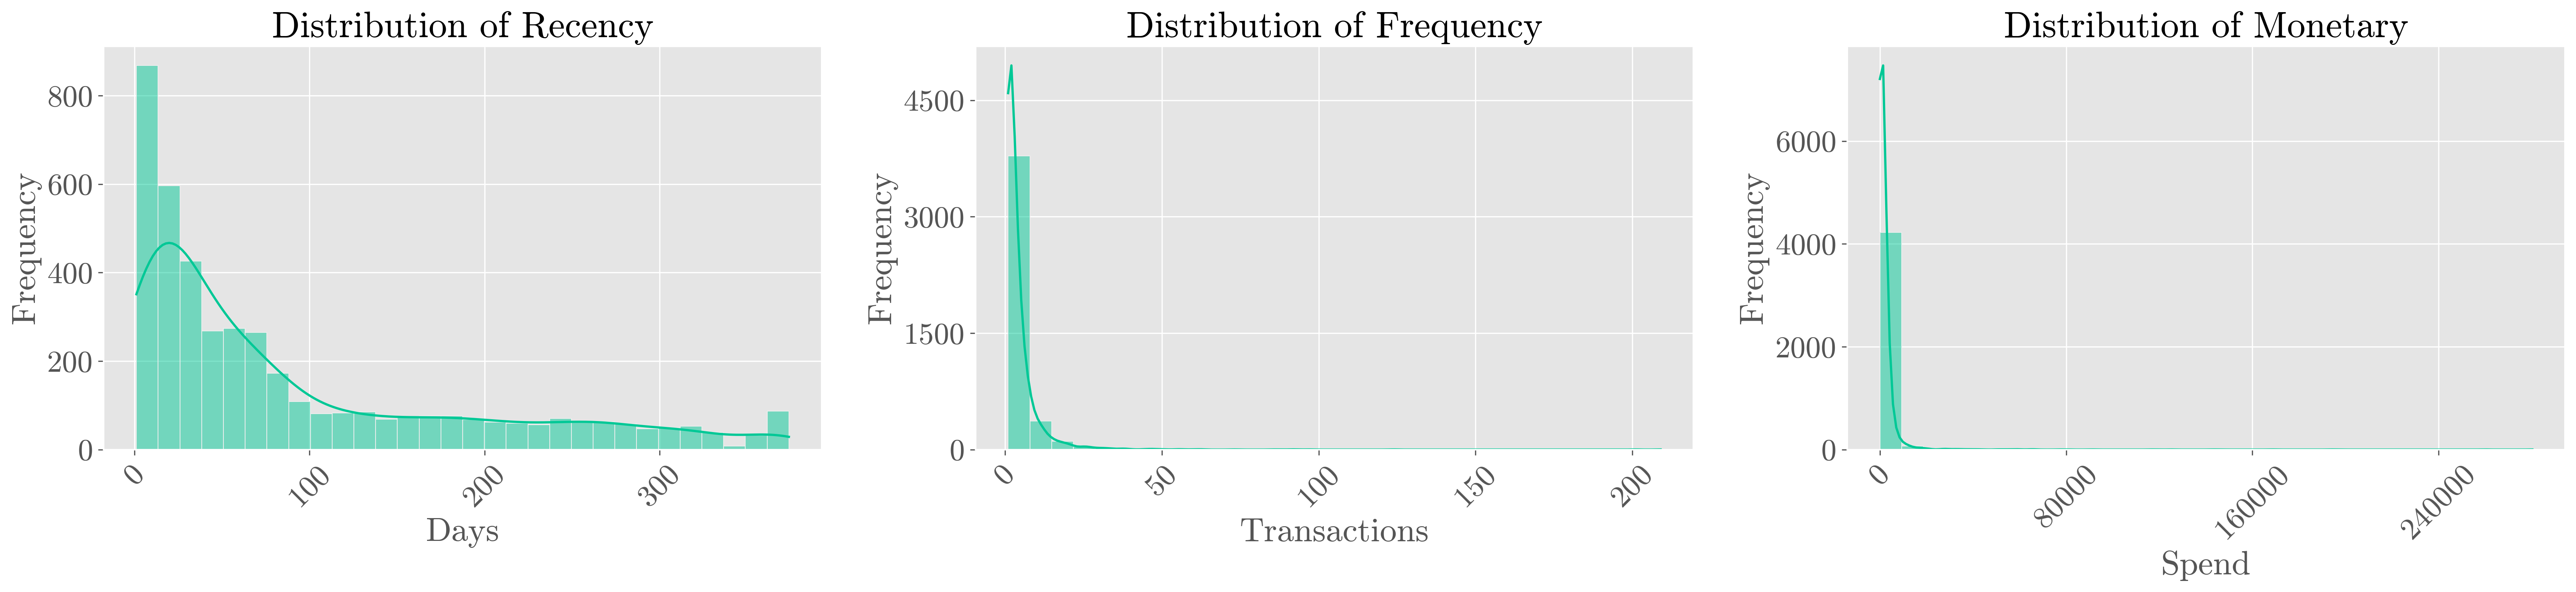

In [62]:
# Set up figure style and layout
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'cmr10'
fig, axes = plt.subplots(1, 3, figsize=(24, 6), dpi=300)

# Plot distribution of Recency
sns.histplot(rfm_df['Recency'], kde=True, bins=30, color='#00c896', ax=axes[0])
axes[0].set(title='Distribution of Recency', xlabel='Days', ylabel='Frequency')
axes[0].tick_params(axis='x', rotation=45)
axes[0].xaxis.set_major_locator(plt.MaxNLocator(nbins=5))
axes[0].yaxis.set_major_locator(plt.MaxNLocator(nbins=5))
axes[0].xaxis.label.set_size(22)
axes[0].yaxis.label.set_size(22)

# Plot distribution of Frequency
sns.histplot(rfm_df['Frequency'], kde=True, bins=30, color='#00c896', ax=axes[1])
axes[1].set(title='Distribution of Frequency', xlabel='Transactions', ylabel='Frequency')
axes[1].tick_params(axis='x', rotation=45)
axes[1].xaxis.set_major_locator(plt.MaxNLocator(nbins=5))
axes[1].yaxis.set_major_locator(plt.MaxNLocator(nbins=5))
axes[1].xaxis.label.set_size(22)
axes[1].yaxis.label.set_size(22)

# Plot distribution of Monetary
sns.histplot(rfm_df['Monetary'], kde=True, bins=30, color='#00c896', ax=axes[2])
axes[2].set(title='Distribution of Monetary', xlabel='Spend', ylabel='Frequency')
axes[2].tick_params(axis='x', rotation=45)
axes[2].xaxis.set_major_locator(plt.MaxNLocator(nbins=5))
axes[2].yaxis.set_major_locator(plt.MaxNLocator(nbins=5))
axes[2].xaxis.label.set_size(22)
axes[2].yaxis.label.set_size(22)

for ax in axes:
    ax.title.set_size(24)

plt.tight_layout(pad=3.0)
plt.show()


We can observe that the distributions of Recency, Frequency, and Monetary are positively skewed (right skewed distribution). There are several ways to transform the data. I will analyze the results of each method and choose the one that best fits the dataset:
- Log transformation
- Square root transformation
- Box-cox transformation
- Cube root transformation

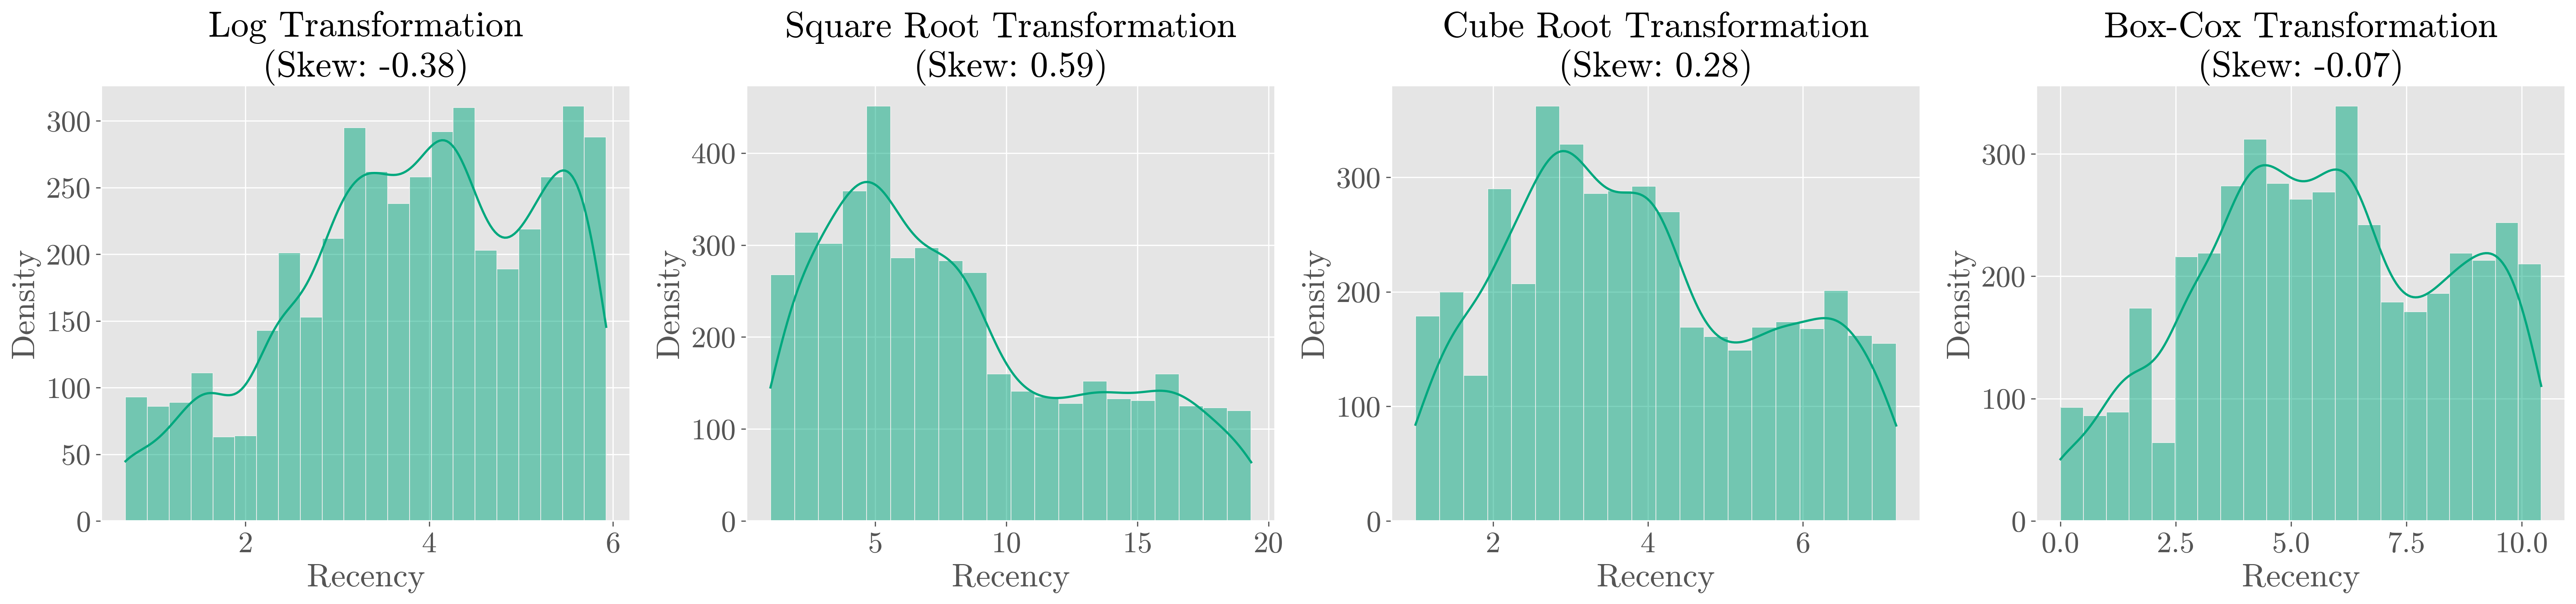

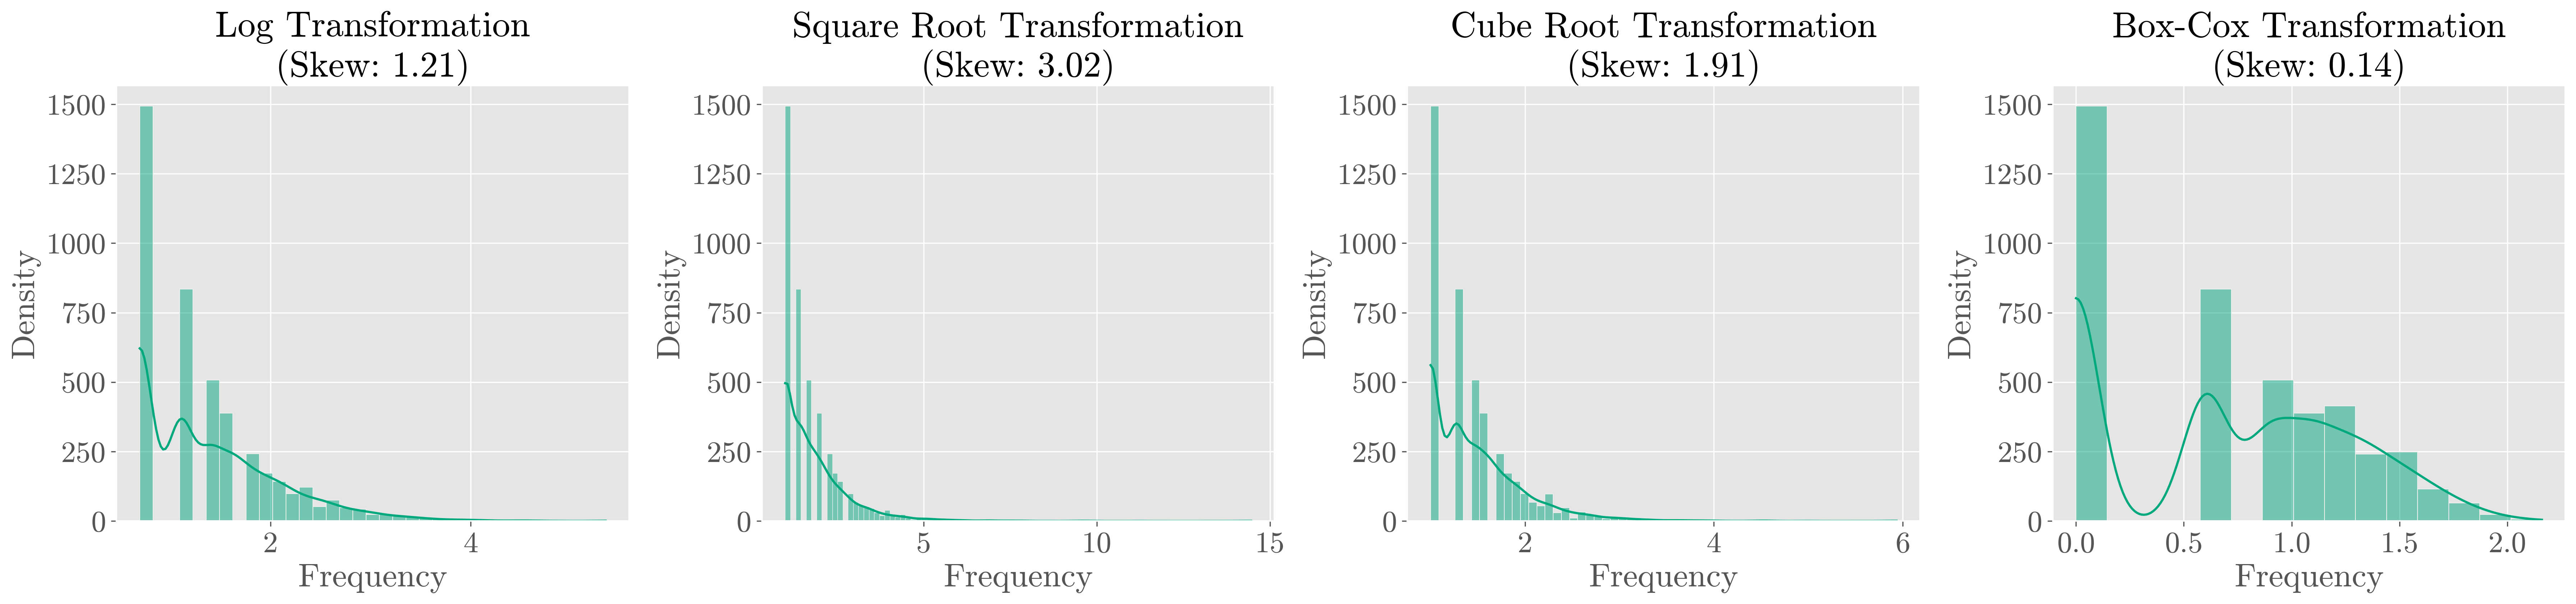

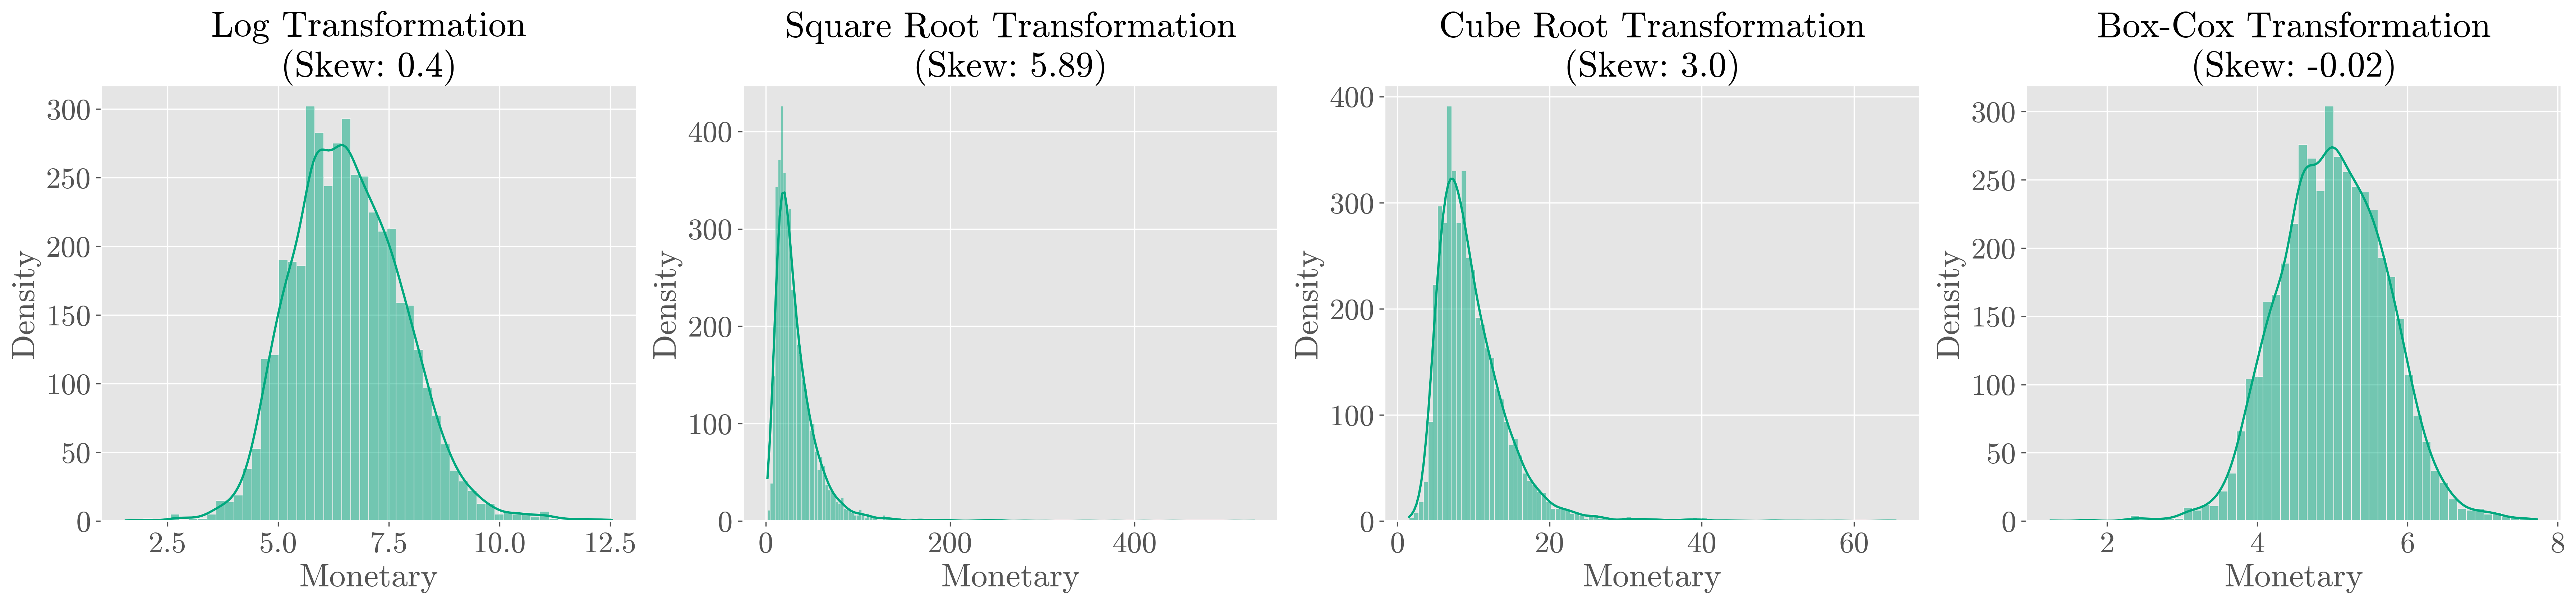

In [74]:
def analysis_transform_method(column):
    # Transformations
    transformations = {
        'Log Transformation': np.log1p(rfm_df[column]),
        'Square Root Transformation': np.sqrt(rfm_df[column]),
        'Cube Root Transformation': np.cbrt(rfm_df[column]),
        'Box-Cox Transformation': pd.Series(stats.boxcox(rfm_df[column] + 1 if (rfm_df[column] <= 0).any() else rfm_df[column])[0])
    }

    # Plot setup
    fig, ax = plt.subplots(1, 4, figsize=(24, 6), dpi=300)
#     fig.suptitle(f'Apply transformation for {column}', fontsize=30, y=1.05)

    # Plot data and calculate skewness
    for (title, transformed_data), subplot in zip(transformations.items(), ax.flatten()):
        sns.histplot(transformed_data, kde=True, ax=subplot, color='#00a87e')
        subplot.set_title(f'{title}\n(Skew: {transformed_data.skew().round(2)})', fontsize=24)
        subplot.set_xlabel(column, fontsize=22)
        subplot.set_ylabel('Density', fontsize=22)
        subplot.tick_params(axis='x', labelsize=20)
        subplot.tick_params(axis='y', labelsize=20)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

analysis_transform_method('Recency')
analysis_transform_method('Frequency')
analysis_transform_method('Monetary')


The Box-Cox transformation provides the best fit for the three metrics because it produces skewness scores closest to 0. This method will therefore be applied to normalize the data.

In [64]:
# Create a new dataframe to prepare for transformation
rfm_transformed_df = pd.DataFrame()

# Apply the Box-Cox transformation to each column of the dataset
for column in rfm_df.columns:
    transformed_data, temp = stats.boxcox(rfm_df[column])
    rfm_transformed_df[column] = transformed_data

rfm_transformed_df.head()

,CustomerID,Recency,Frequency,Monetary
0,1507.697564,10.039089,0.000000,7.252373
1,1507.788717,0.737107,1.339109,5.993348
2,1507.879868,6.460361,1.056519,5.546730
3,1507.971017,3.855960,0.000000,5.534888
4,1508.062163,9.900640,0.000000,4.589198


The K-means algorithm is sensitive to high values and the scale them. This makes scaling the data necessary to ensure that the three metrics have the same weight when calculating the distance to the centroid.

In [65]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_transformed_df[['Recency', 'Frequency', 'Monetary']])

rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])
rfm_scaled_df.insert(0, 'CustomerID', rfm_transformed_df['CustomerID'])

rfm_scaled_df.head()

,CustomerID,Recency,Frequency,Monetary
0,1507.697564,1.624870,-1.184682,3.140439
1,1507.788717,-1.841636,1.159357,1.378499
2,1507.879868,0.291210,0.664699,0.753480
3,1507.971017,-0.679354,-1.184682,0.736908
4,1508.062163,1.573275,-1.184682,-0.586537


<a name='3'></a>
## 3 - Applying K-means clustering

<a name='3.1'></a>
### 3.1 - Determine the optimal number of k clusters using Elbow method
At this stage, we need to determine the number of clusters k before conducting the main algorithm in second stage. I use Sum Squared Error (SSE) optimized by using the Elbow Method

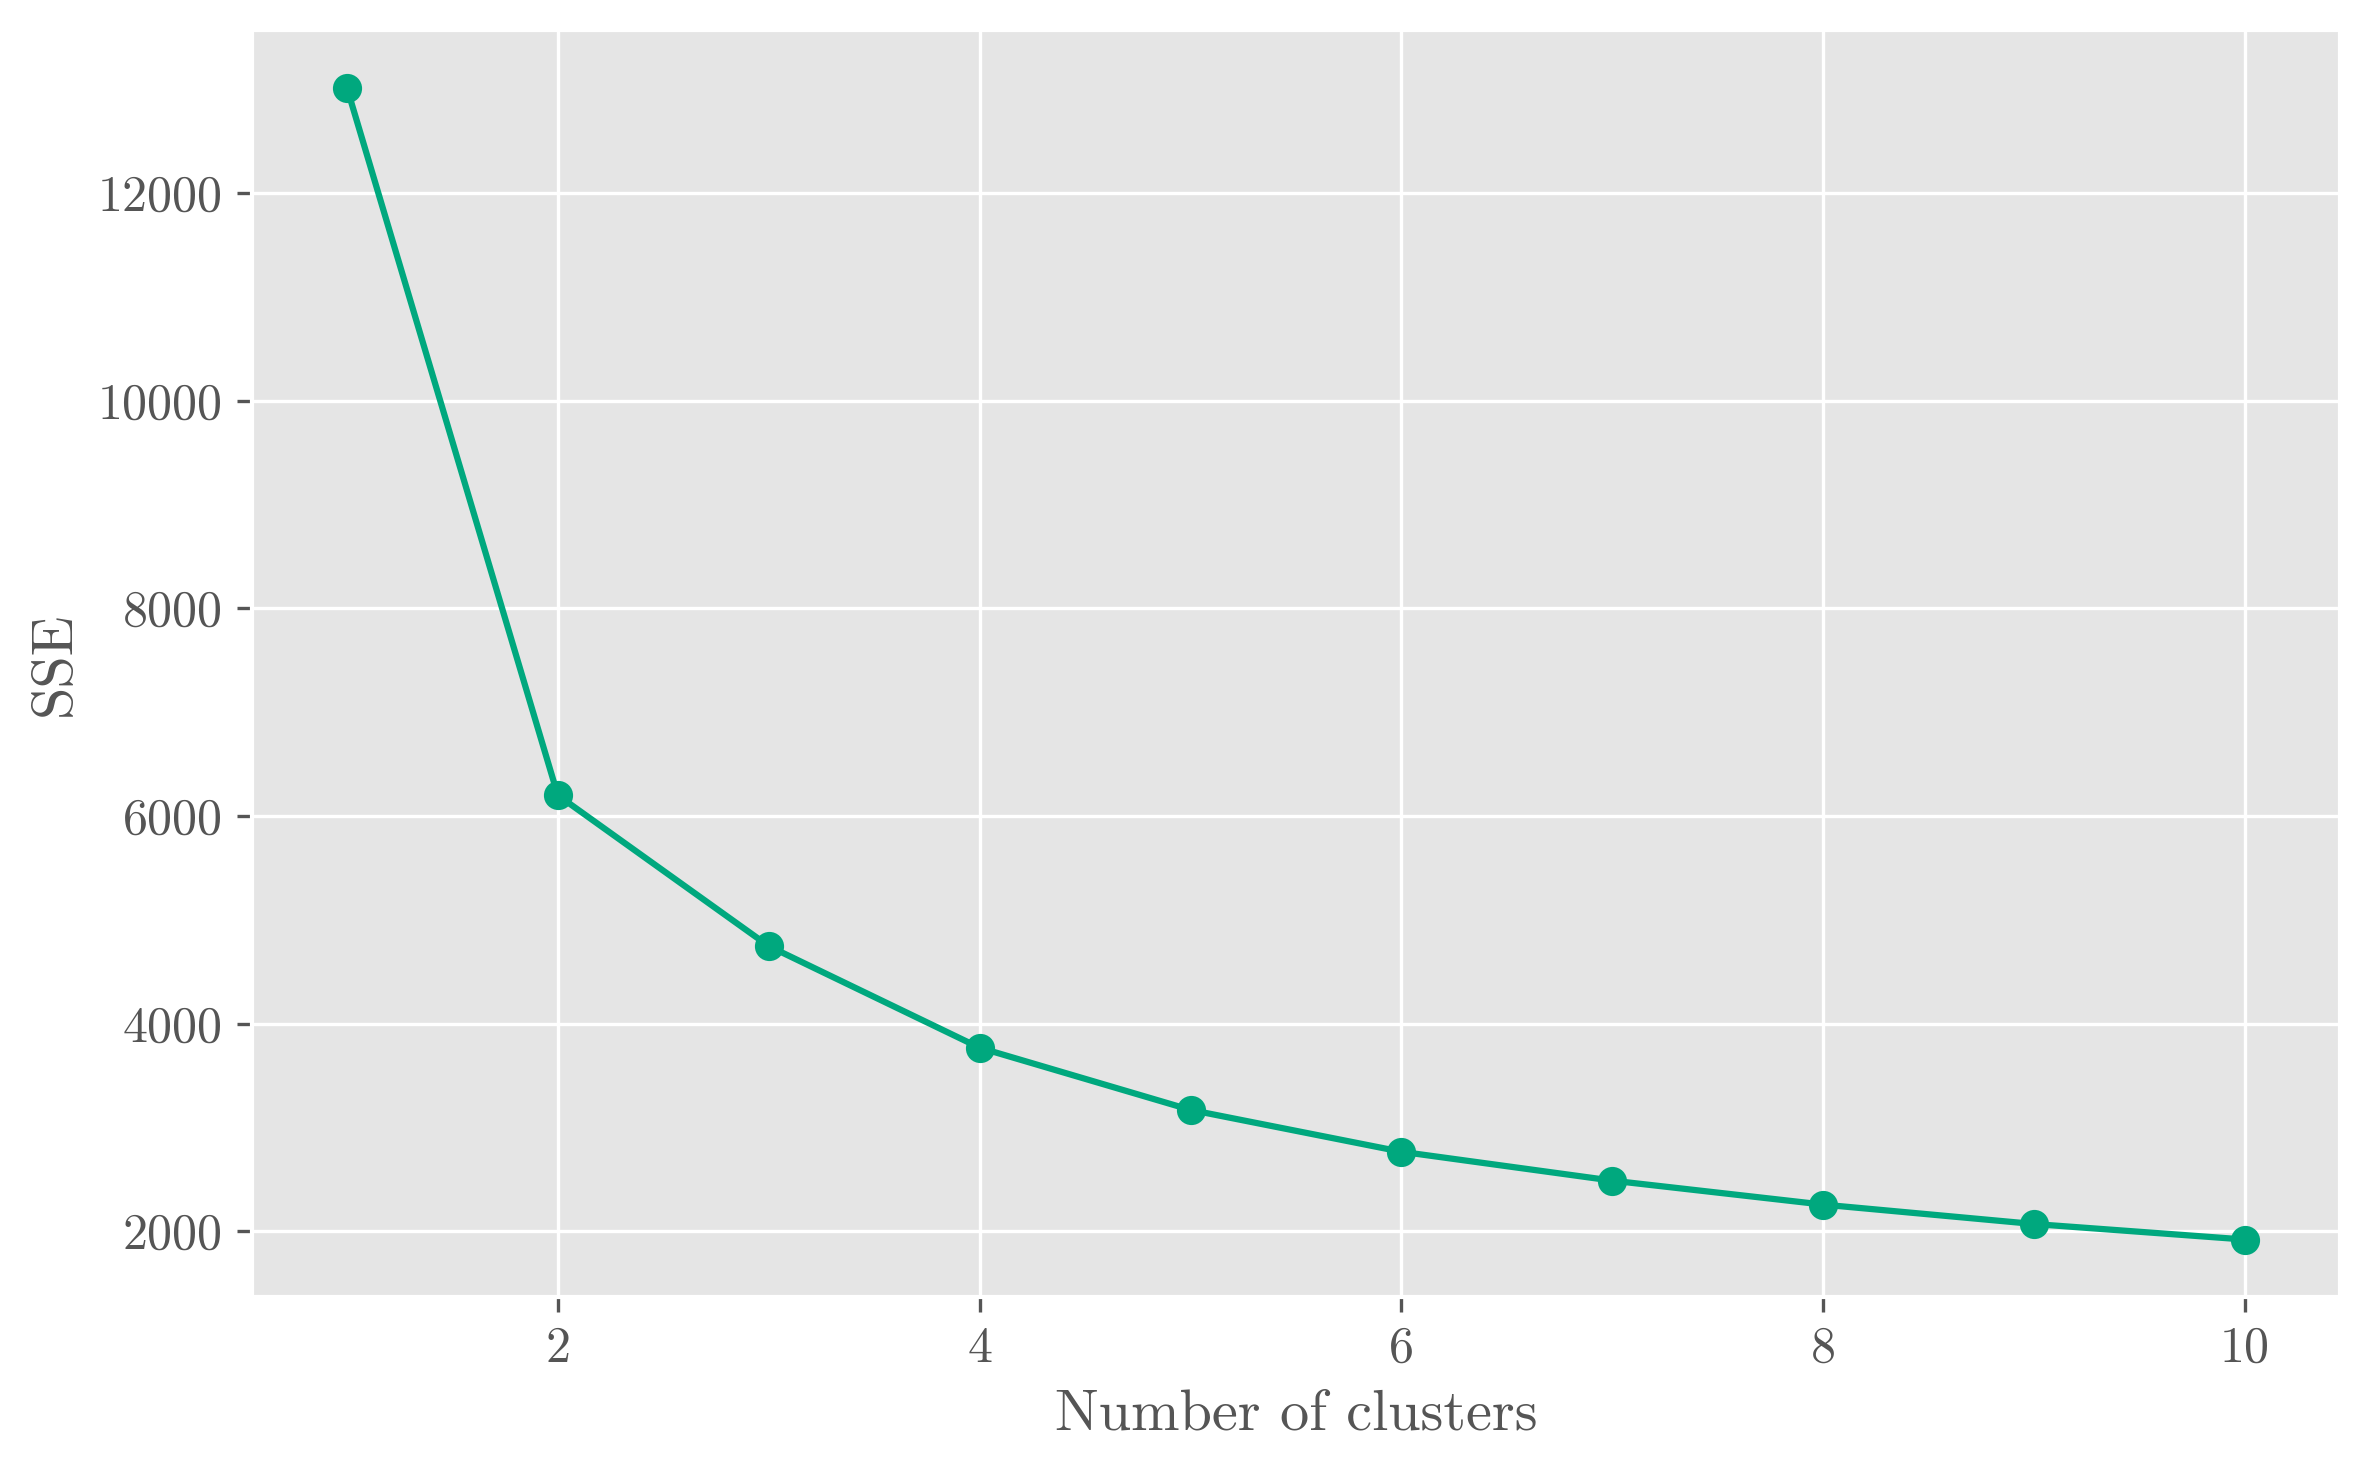

In [89]:
sse = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled_df[['Recency', 'Frequency', 'Monetary']])
    sse.append(kmeans.inertia_)

# Plot the change in SSE as k increases
plt.figure(figsize=(8, 5), dpi=300)
plt.plot(k_range, sse, marker='o', color='#00a87e')
plt.xlabel('Number of clusters', fontsize=14)
plt.ylabel('SSE', fontsize=14)
# plt.title('Elbow method for optimal clusters', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

plt.subplots_adjust(left=0.15, right=0.85)

plt.tight_layout()
plt.show()


<a name='3.2'></a>
### 3.2 - Implementing the K-means algorithm with k clusters

In [110]:
# Create a list to store the results of each trial
results = []

# Run the K-means algorithm 10 times with different initial centroids and k=3
for i in range(10):
    kmeans = KMeans(n_clusters=3) # , random_state=42 + i
    clusters = kmeans.fit_predict(rfm_scaled_df[['Recency', 'Frequency', 'Monetary']])
    
    # Calculate the number of points in each cluster
    num_points = np.bincount(clusters, minlength=3)
    rounded_centers = np.round(kmeans.cluster_centers_, 2)
    
    results.append({
        'Trial': i + 1,
        'Cluster 1 Centroid': tuple(rounded_centers[0]),
        'Cluster 2 Centroid': tuple(rounded_centers[1]),
        'Cluster 3 Centroid': tuple(rounded_centers[2]),
        'Number of Points': tuple(num_points),
        'SSE': round(kmeans.inertia_, 2)
    })
    
results_df = pd.DataFrame(results)
results_df

,Trial,Cluster 1 Centroid,Cluster 2 Centroid,Cluster 3 Centroid,Number of Points,SSE
0,1,"(0.71, -1.04, -0.89)","(-1.05, 1.23, 1.15)","(-0.04, 0.25, 0.14)","(1649, 1072, 1617)",4745.72
1,2,"(-1.04, 1.23, 1.15)","(0.71, -1.04, -0.89)","(-0.04, 0.25, 0.14)","(1072, 1649, 1617)",4745.73
2,3,"(-0.03, 0.25, 0.14)","(-1.04, 1.22, 1.15)","(0.71, -1.05, -0.89)","(1614, 1077, 1647)",4745.75
3,4,"(0.71, -1.05, -0.89)","(-1.05, 1.23, 1.15)","(-0.03, 0.25, 0.14)","(1649, 1074, 1615)",4745.71
4,5,"(0.71, -1.04, -0.89)","(-1.05, 1.23, 1.15)","(-0.04, 0.25, 0.14)","(1649, 1072, 1617)",4745.72
5,6,"(-1.04, 1.22, 1.15)","(0.71, -1.05, -0.89)","(-0.03, 0.25, 0.13)","(1083, 1648, 1607)",4745.68
6,7,"(0.71, -1.05, -0.89)","(-1.04, 1.22, 1.14)","(-0.02, 0.25, 0.13)","(1636, 1087, 1615)",4745.88
7,8,"(-0.04, 0.25, 0.14)","(0.71, -1.04, -0.89)","(-1.05, 1.23, 1.15)","(1617, 1649, 1072)",4745.72
8,9,"(-0.04, 0.25, 0.14)","(0.71, -1.05, -0.89)","(-1.03, 1.22, 1.15)","(1607, 1648, 1083)",4745.68
9,10,"(-1.04, 1.23, 1.15)","(-0.03, 0.25, 0.14)","(0.71, -1.05, -0.89)","(1075, 1614, 1649)",4745.70


Bonus: construct K-means algorithm step by step

In [78]:
# Step 1: Create initial centroids by selecting k rows from X as the initial centers.
def kmeans_init_centers(X, k):
    return X[np.random.choice(X.shape[0], k, replace=False), :]

# Step 2: Label each data point by calculating the pairwise distances between the data points and the centers, then assign each data point to the index of the closest center
def kmeans_assign_labels(X, centers):
    D = cdist(X, centers)
    return np.argmin(D, axis=1)

# Step 3: Find the new centers by collecting all points assigned to the k-th cluster and calculating their average
def kmeans_find_centers(X, labels, K):
    centers = np.zeros((K, X.shape[1]))
    for k in range(K):
        Xk = X[labels == k, :]
        centers[k, :] = np.mean(Xk, axis=0)
    return centers

# Step 4: Check convergence if two sets of centers are the same
def has_converged(centers, new_centers):
    return set([tuple(a) for a in centers]) == set([tuple(a) for a in new_centers])

# Create K-means programming combining all the above steps.
def run_kmeans(rfm_scaled_df, K):
    X = rfm_scaled_df[['Recency', 'Frequency', 'Monetary']].values
    centers = kmeans_init_centers(X, K)                   # Step 1: Create initial centroids
    
    while True:
        labels = kmeans_assign_labels(X, centers)         # Step 2: Label each data point
        new_centers = kmeans_update_centers(X, labels, K) # Step 3: Find the new centers
        if has_converged(centers, new_centers):           # Step 4: Check convergence
            break
        centers = new_centers                             # Step 5: Update new centroids
    return labels, centers

labels, centers = run_kmeans(rfm_scaled_df, 4)

# Thêm nhãn cụm vào DataFrame
rfm_scaled_df['Cluster'] = labels
rfm_scaled_df.head()

,CustomerID,Recency,Frequency,Monetary,Cluster
0,1507.697564,1.624870,-1.184682,3.140439,2
1,1507.788717,-1.841636,1.159357,1.378499,1
2,1507.879868,0.291210,0.664699,0.753480,2
3,1507.971017,-0.679354,-1.184682,0.736908,0
4,1508.062163,1.573275,-1.184682,-0.586537,3
